In [1]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
!python -c "import onnxruntime" || pip install -q onnxruntime
%matplotlib inline

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.3.1 requires torch==2.3.1, but you have torch 2.8.0 which is incompatible.
torchvision 0.18.1 requires torch==2.3.1, but you have torch 2.8.0 which is incompatible.


In [1]:
import os
import shutil
import tempfile
import time
import matplotlib.pyplot as plt
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader, decollate_batch
from monai.handlers.utils import from_engine
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import SegResNet
from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    Invertd,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd,
)
from monai.utils import set_determinism
import onnxruntime
from tqdm import tqdm

import torch

print_config()


MONAI version: 1.6.dev2537
Numpy version: 1.26.2
Pytorch version: 2.8.0+cpu
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: ca9fa44c33f3b7c073263938e7a70b2fa6123044
MONAI __file__: c:\Users\<username>\AppData\Local\Programs\Python\Python310\lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.0
scikit-image version: 0.24.0
scipy version: 1.11.4
Pillow version: 10.1.0
Tensorboard version: 2.15.1
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.66.4
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.8
pandas version: 2.1.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: 4.48.0
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: 1.1.3
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For deta

In [2]:
set_determinism(seed=0)

In [2]:
set_determinism(seed=0)

In [3]:
directory=os.environ.get(r'F:\Project\Brain')
if directory is not None:
    os.makedirs(directory,exist_ok=True)
root_dir=tempfile.mkdtemp() if directory is None else directory
print(root_dir)

C:\Users\NoteBook\AppData\Local\Temp\tmpmnkul5yj


In [4]:
directory=os.environ.get('F:\Project\Brain')
root_dir=tempfile.mkdtemp() if directory is None else directory
print(root_dir)

C:\Users\NoteBook\AppData\Local\Temp\tmpsnh0srnl


In [4]:


class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    """
    Convert labels to multi channels based on brats classes:
    label 1 is the peritumoral edema
    label 2 is the GD-enhancing tumor
    label 3 is the necrotic and non-enhancing tumor core
    The possible classes are TC (Tumor core), WT (Whole tumor)
    and ET (Enhancing tumor).

    """

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            # merge label 2 and label 3 to construct TC
            result.append(torch.logical_or(d[key] == 2, d[key] == 3))
            # merge labels 1, 2 and 3 to construct WT
            result.append(torch.logical_or(torch.logical_or(d[key] == 2, d[key] == 3), d[key] == 1))
            # label 2 is ET
            result.append(d[key] == 2)
            d[key] = torch.stack(result, axis=0).float()
        return d



In [5]:
class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    def __call__(self,data):
        d=dict(data)
        for key in self.keys:
            result=[]
            result.append(torch.logical_or(d[key]==2,d[key]==3))
            result.append(torch.logical_or(d[key]==2,d[key]==3,d[key]==1))
            result.append(d[key]==2)
            d[key]=torch.stack(result,axis=0).float()
        return d

In [5]:
train_transform=Compose(
    [
        LoadImaged(keys=['image','label']),
        EnsureChannelFirstd(keys='image'),
        EnsureTyped(keys=['image','label']),
        ConvertToMultiChannelBasedOnBratsClassesd(keys='label'),
        Orientationd(keys=['image','label'],axcodes='RAS'),
        Spacingd(
            keys=['image','label'],
            pixdim=(1.0,1.0,1.0),
            mode=('bilnear','nearest')
        ),
        RandSpatialCropd(keys=["image", "label"], roi_size=[224, 224, 144], random_size=False),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
        RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
    ]
    
)

c:\Users\NoteBook\AppData\Local\Programs\Python\Python310\lib\site-packages\monai\utils\deprecate_utils.py:321: FutureWarning: monai.transforms.spatial.dictionary Orientationd.__init__:labels: Current default value of argument `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` was changed in version None from `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` to `labels=None`. Default value changed to None meaning that the transform now uses the 'space' of a meta-tensor, if applicable, to determine appropriate axis labels.
  warn_deprecated(argname, msg, warning_category)


In [13]:
train_transform=Compose(
    [
        LoadImaged(keys=['image','label']),
        EnsureChannelFirstd(keys='image'),
        EnsureTyped(keys=['image','label']),
        ConvertToMultiChannelBasedOnBratsClassesd(keys='label'),
        Orientationd(keys=['image','label'],axcodes='RAS'),
        Spacingd(
            keys=['image','label'],
            pixdim=(1.0,1.0,1.0),
            mode=('bilnear','label')
        ),
        RandSpatialCropd(keys=['image','label'],roi_size=[224,224,144],random_size=False),
        RandFlipd(keys=['image','label'],prob=0.5,spatial_axis=0),
        RandFlipd(keys=['image','label'],prob=0.5,spatial_axis=1),
        RandFlipd(keys=['image','label'],prob=0.5,spatial_axis=2),
        NormalizeIntensityd(keys='image',nonzero=True,channel_wise=True),
        RandScaleIntensityd(keys='image',factors=0.1,prob=1.0),
        RandShiftIntensityd(keys='image',offsets=0.1,prob=1.0),

    ]
)

c:\Users\NoteBook\AppData\Local\Programs\Python\Python310\lib\site-packages\monai\utils\deprecate_utils.py:321: FutureWarning: monai.transforms.spatial.dictionary Orientationd.__init__:labels: Current default value of argument `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` was changed in version None from `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` to `labels=None`. Default value changed to None meaning that the transform now uses the 'space' of a meta-tensor, if applicable, to determine appropriate axis labels.
  warn_deprecated(argname, msg, warning_category)


In [6]:
val_transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)


In [14]:
val_transform=Compose(
    [
        LoadImaged(keys=['image','label']),
        EnsureChannelFirstd(keys='image'),
        EnsureTyped(keys=['image','label']),
        ConvertToMultiChannelBasedOnBratsClassesd(keys='label'),
        Orientationd(keys=['image','label'],axcodes='RAS'),
        Spacingd(
            keys=['image','label'],
            pixdim=(1.0,1.0,1.0),
            mode=('bilnear','nearest'),
        ),
        NormalizeIntensityd(keys='image',nonzero=True,channel_wise=True),
    ]
)

c:\Users\NoteBook\AppData\Local\Programs\Python\Python310\lib\site-packages\monai\utils\deprecate_utils.py:321: FutureWarning: monai.transforms.spatial.dictionary Orientationd.__init__:labels: Current default value of argument `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` was changed in version None from `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` to `labels=None`. Default value changed to None meaning that the transform now uses the 'space' of a meta-tensor, if applicable, to determine appropriate axis labels.
  warn_deprecated(argname, msg, warning_category)


In [7]:
# here we don't cache any data in case out of memory issue
train_ds = DecathlonDataset(
    root_dir=r"F:\Project\Brain",
    task="Task01_BrainTumour",
    transform=train_transform,
    section="training",
    download=False,
    cache_rate=0.0,
    num_workers=4,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=4)
val_ds = DecathlonDataset(
    root_dir=r"F:\Project\Brain",
    task="Task01_BrainTumour",
    transform=val_transform,
    section="validation",
    download=False,
    cache_rate=0.0,
    num_workers=4,
)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4)

In [17]:
train_ds=DecathlonDataset(
    root_dir=r"F:\Project\Brain",
    task="Task01_BrainTumour",
    transform=train_transform,
    section='training',
    download=False,
    cache_rate=0.0,
    num_workers=4
)
train_loader=DataLoader(train_ds, batch_size=1 ,shuffle=True,num_workers=4)

val_ds=DecathlonDataset(
    root_dir=r"F:\Project\Brain",
    task="Task01_BrainTumour",
    transform=val_transform,
    section='validatoin',
    download=False,
    cache_rate=0.0,
    num_workers=4,
)
val_loader=DataLoader(val_ds,batch_size=1,shuffle=True,num_workers=4)

image shape:torch.Size([4, 240, 240, 155])


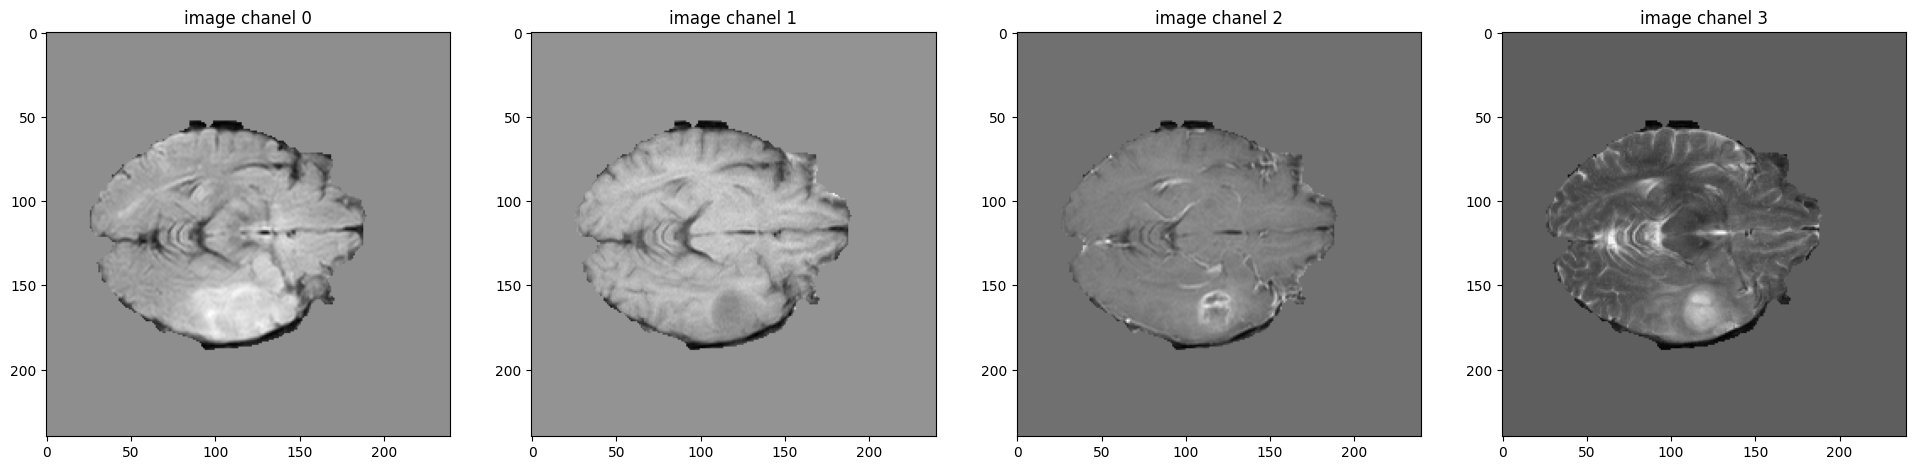

In [ ]:
val_data_example=val_ds[2]
print(f"image shape:{val_data_example['image'].shape}")
plt.figure("image",(24,6))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.title(f"image chanel {i}")
    plt.imshow(val_data_example["image"][i, :, :, 60].detach().cpu(),cmap='gray')
plt.show()

In [8]:
val_data_example=val_ds[2]
print(f"image shape:{val_data_example['image'].shape}")


image shape:torch.Size([4, 240, 240, 155])


label shapetorch.Size([3, 240, 240, 155])


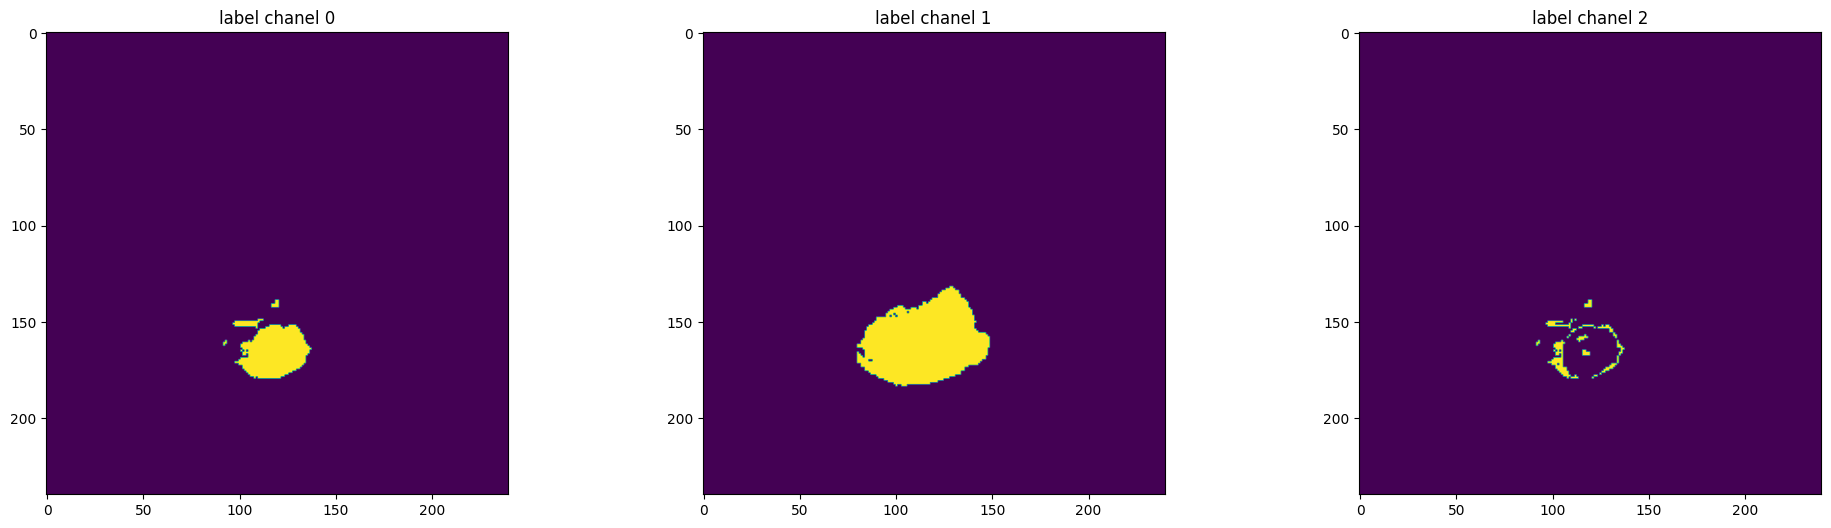

In [ ]:
print(f"label shape{val_data_example['label'].shape}")
plt.figure('image',(24,6))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.title(f"label chanel {i}")
    plt.imshow(val_data_example['label'][i, :, :,60].detach().cpu())
plt.show()

In [ ]:
max_epochs=300
val_interval=1
VAL_AMP=False

device=torch.device("cpu") # if using GPU => "cuda:0"
model=SegResNet(
    blocks_down=[1,2,2,4],
    blocks_up=[1,1,1],
    init_filters=16,
    in_channels=4,
    out_channels=3,
    dropout_prob=0.2,
).to(device)

In [ ]:
loss_function=DiceLoss(smooth_nr=0,smooth_dr=1e-5,squared_pred=True,to_onehot_y=False,sigmoid=True)

In [ ]:
optimizer=torch.optim.Adam(model.parameters(),1e-4,weight_decay=1e-5,)

In [ ]:
lr_schedular=torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=max_epochs)

In [ ]:
dice_metric=DiceMetric(include_background=True,reduction="mean")
dice_metric_batch=DiceMetric(include_background=True,reduction="mean_batch")

In [ ]:
post_trans=Compose([Activations(sigmoid=True),AsDiscrete(threshold=0.5)])

In [ ]:
def inference(input):
    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(240,240,160),
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
        )

In [ ]:
# use amp to accelerate training
scaler = torch.GradScaler("cuda")
# enable cuDNN benchmark
torch.backends.cudnn.benchmark = True


c:\Users\NoteBook\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\amp\grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [ ]:
best_metric = -1
best_metric_epoch = -1
best_metrics_epochs_and_time = [[], [], []]
epoch_loss_values = []
metric_values = []
metric_values_tc = []
metric_values_wt = []
metric_values_et = []

total_start = time.time()
for epoch in range(max_epochs):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step_start = time.time()
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        with torch.autocast("cuda"):
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}"
            f", train_loss: {loss.item():.4f}"
            f", step time: {(time.time() - step_start):.4f}"
        )
    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                val_outputs = inference(val_inputs)
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                dice_metric(y_pred=val_outputs, y=val_labels)
                dice_metric_batch(y_pred=val_outputs, y=val_labels)

            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            metric_batch = dice_metric_batch.aggregate()
            metric_tc = metric_batch[0].item()
            metric_values_tc.append(metric_tc)
            metric_wt = metric_batch[1].item()
            metric_values_wt.append(metric_wt)
            metric_et = metric_batch[2].item()
            metric_values_et.append(metric_et)
            dice_metric.reset()
            dice_metric_batch.reset()

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                best_metrics_epochs_and_time[0].append(best_metric)
                best_metrics_epochs_and_time[1].append(best_metric_epoch)
                best_metrics_epochs_and_time[2].append(time.time() - total_start)
                torch.save(
                    model.state_dict(),
                    os.path.join(root_dir, "best_metric_model.pth"),
                )
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f" tc: {metric_tc:.4f} wt: {metric_wt:.4f} et: {metric_et:.4f}"
                f"\nbest mean dice: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
total_time = time.time() - total_start

----------
epoch 1/300


-------------------------------------------------------------------------------------------------------------------------------------------------------

In [2]:


import os
import shutil
import tempfile
import time
import matplotlib.pyplot as plt
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader, decollate_batch
from monai.handlers.utils import from_engine
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import SegResNet
from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    Invertd,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd,
)
from monai.utils import set_determinism
import onnxruntime
from tqdm import tqdm

import torch

print_config()




MONAI version: 1.6.dev2537
Numpy version: 1.26.4
Pytorch version: 2.3.0+cpu
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: ca9fa44c33f3b7c073263938e7a70b2fa6123044
MONAI __file__: c:\Users\<username>\AppData\Local\Programs\Python\Python310\lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.0
scikit-image version: 0.24.0
scipy version: 1.11.4
Pillow version: 11.3.0
Tensorboard version: 2.15.1
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.18.0+cpu
tqdm version: 4.66.4
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.8
pandas version: 2.1.3
einops version: 0.8.1
transformers version: 4.48.0
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: 1.1.3
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, ple

In [3]:
set_determinism(seed=0)

In [27]:
class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    def __call__(self,data):
        d=dict(data)
        for key in self.keys:
            result=[]
            result.append(torch.logical_or(d[key]==2,d[key]==3))
            result.append(torch.logical_or(d[key]==2,d[key]==3,d[key]==1))
            result.append(d[key]==2)
            d[key]=torch.stack(result,axis=0).float()
        return d

In [28]:
train_transform=Compose(
    [
        LoadImaged(keys=['image','label']),
        EnsureChannelFirstd(keys='image'),
        EnsureTyped(keys=['image','label']),
        ConvertToMultiChannelBasedOnBratsClassesd(keys=['label']),
        Orientationd(keys=['image','label'],axcodes='RAS'),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        RandSpatialCropd(keys=['image','label'],roi_size=[224,224,144],random_size=False),
        RandFlipd(keys=['image','label'],prob=0.5,spatial_axis=0),
        RandFlipd(keys=['image','label'],prob=0.5,spatial_axis=1),
        RandFlipd(keys=['image','label'],prob=0.5,spatial_axis=2),
        NormalizeIntensityd(keys='image',nonzero=True,channel_wise=True),
        RandScaleIntensityd(keys='image',factors=0.1,prob=1.0),
        RandShiftIntensityd(keys='image',offsets=0.1,prob=1.0),
    
    ]
)

c:\Users\NoteBook\AppData\Local\Programs\Python\Python310\lib\site-packages\monai\utils\deprecate_utils.py:321: FutureWarning: monai.transforms.spatial.dictionary Orientationd.__init__:labels: Current default value of argument `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` was changed in version None from `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` to `labels=None`. Default value changed to None meaning that the transform now uses the 'space' of a meta-tensor, if applicable, to determine appropriate axis labels.
  warn_deprecated(argname, msg, warning_category)


In [29]:
val_transform=(
    [
        LoadImaged(keys=['image','label']),
        EnsureChannelFirstd(keys='image'),
        EnsureTyped(keys=['image','label']),
        ConvertToMultiChannelBasedOnBratsClassesd(keys='label'),
        Orientationd(keys=['image','label'],axcodes="RAS"),
        Spacingd(
            keys=['image','label'],
            pixdim=(1.0,1.0,1.0),
            mode=('billnear','nearest'),
        ),
        NormalizeIntensityd(keys=['image'],nonzero=True,channel_wise=True),
    ]
)

In [30]:
train_ds=DecathlonDataset(
    root_dir=r'F:\Project\Brain',
    task='Task01_BrainTumour',
    transform=train_transform,
    section='training',
    download=False,
    cache_rate=0.0,
    num_workers=4
)
train_loader=DataLoader(train_ds,batch_size=1,shuffle=True,num_workers=4)

In [31]:
val_ds=DecathlonDataset(
    root_dir=r'F:\Project\Brain',
    task='Task01_BrainTumour',
    transform=train_transform,
    section='validation',
    download=False,
    cache_rate=0.0,
    num_workers=4
)
val_loader=DataLoader(val_ds,batch_size=1,shuffle=True,num_workers=4)

In [33]:


# pick one image from DecathlonDataset to visualize and check the 4 channels
val_data_example = val_ds[2]
print(f"image shape: {val_data_example['image'].shape}")
plt.figure("image", (24, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(val_data_example["image"][i, :, :, 60].detach().cpu(), cmap="gray")
plt.show()
# also visualize the 3 channels label corresponding to this image
print(f"label shape: {val_data_example['label'].shape}")
plt.figure("label", (18, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(f"label channel {i}")
    plt.imshow(val_data_example["label"][i, :, :, 60].detach().cpu())
plt.show()



RuntimeError: applying transform <__main__.ConvertToMultiChannelBasedOnBratsClassesd object at 0x0000016CF6D473A0>

In [32]:
val_data_example = val_ds[2]
print(f"image shape: {val_data_example['image'].shape}")

RuntimeError: applying transform <__main__.ConvertToMultiChannelBasedOnBratsClassesd object at 0x0000016CF6D473A0>